In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt #for imshow
from matplotlib.collections import PatchCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from scipy import signal
from scipy.io import loadmat
from scipy.stats import gmean
from scipy.spatial import distance
import h5py
import hdf5storage
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df_tr = pd.read_csv('data_306k_TRAIN.csv')
df_val = pd.read_csv('data_306k_VAL.csv')
df_test = pd.read_csv('data_306k_TEST.csv')


In [3]:
df_well_test = pd.read_csv('data_306k_TEST_WELL.csv')


In [ ]:
#To categorize data according to well
df_well_test.iloc[np.asarray(np.where(df_well_test.iloc[:,0]==1)).tolist()[0],:].iloc[:,3:453]

In [63]:
g = globals()
for i in range(1,481):
    if(i==199):
        continue
    label_array = '306k_labels_{0}'.format(i)
    trace_array = '306k_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_well_test.iloc[np.asarray(np.where(df_well_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,3:453].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_well_test.iloc[np.asarray(np.where(df_well_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1].values
    

In [4]:
#Train set 
X_train = df_tr.iloc[:,2:452].values
y_train = df_tr.iloc[:,0].values

#Val set
X_val = df_val.iloc[:,2:452].values
y_val = df_val.iloc[:,0].values

#Test set
X_test = df_test.iloc[:,2:452].values
y_test = df_test.iloc[:,0].values

In [2]:

DATASET_INDEX = 47

MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

TRAINABLE = True


def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(128)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    model.summary()

    # add load model code here to fine-tune

    return model

In [5]:
X_train = X_train.reshape(X_train.shape[0],1, 450)
X_test = X_test.reshape(X_test.shape[0], 1, 450)
X_val = X_val.reshape(X_val.shape[0],1, 450)

y_val = np_utils.to_categorical(y_val, 4)
y_test = np_utils.to_categorical(y_test, 4)
y_train = np_utils.to_categorical(y_train, 4)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 450)       0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 450, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 450, 128)     1408        permute_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 450, 128)     512         conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation

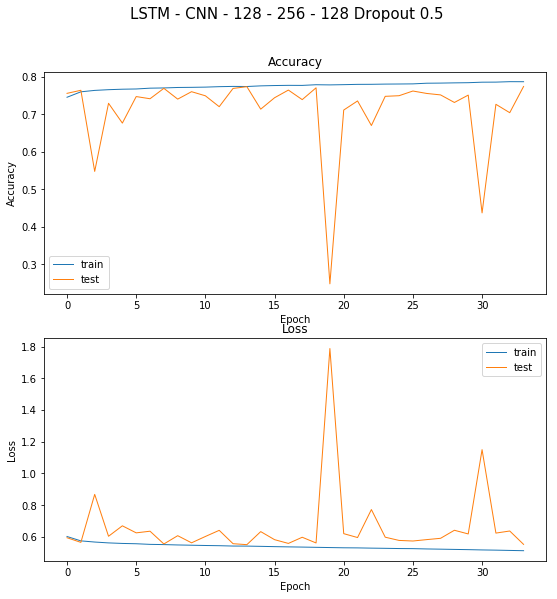

In [7]:
x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nEvaluating : ")
cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h = model.fit(X_train,y_train,
                             epochs = 150,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 128 - 256 - 128 Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

model.save('timeseries_lstm_cnn_50epochs.h5')
#return accuracy

## Test Data - Well - Predictions

In [65]:
confidence_list = []
for i in range(1,481):
    if(i==199):
        continue
    g['306k_predictions_{0}'.format(i)] = []
    g['306k_predictions_{0}'.format(i)] = model.predict([g['306k_trace_{0}'.format(i)]])
    
    g['306k_plabels_{0}'.format(i)] = np.argmax( g['306k_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['306k_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['306k_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.7368945  0.11649542 0.14540614 0.00120378]


[0.7138518  0.19777344 0.08748781 0.00088706]


[0.7006174  0.09357427 0.20441417 0.00139411]


[0.3797257  0.03504284 0.58190536 0.00332605]


[0.7027826  0.11637665 0.17985892 0.00098197]


[0.5536887  0.34058607 0.10510856 0.00061672]


[0.6864042  0.08839753 0.22416884 0.00102946]


[0.48948827 0.04513574 0.46092227 0.00445376]


[0.69668484 0.09724487 0.20513222 0.00093812]


[5.7105684e-01 3.7394920e-01 5.4583624e-02 4.1031808e-04]


[0.618407   0.07687406 0.3032935  0.00142543]


[0.48454708 0.03977789 0.47270912 0.00296594]


[0.29614353 0.01615943 0.68063873 0.00705844]


[0.7287708  0.11572141 0.15178528 0.00372255]


[5.3574574e-01 4.3189698e-01 3.2121748e-02 2.3549305e-04]


[0.72259766 0.12466557 0.15197332 0.00076351]


[0.393163   0.01787522 0.5865492  0.00241271]


[0.7193175  0.12539941 0.15446596 0.00081706]


[0.5393379  0.37466264 0.08534148 0.00065811]


[7.3685098e-01 1.4342484e-01 1.1915663e-01 5.6747138e-04]


[0.1

[7.0926589e-01 2.2109969e-01 6.9112644e-02 5.2172091e-04]


[4.3619874e-01 5.3411222e-01 2.9432010e-02 2.5704250e-04]


[0.6812451  0.23915085 0.07855938 0.00104472]


[0.08628786 0.01055267 0.89661413 0.00654525]


[0.12566534 0.00937506 0.8628564  0.00210314]


[6.8567884e-01 2.4636443e-01 6.7283101e-02 6.7366316e-04]


[6.5886664e-01 2.8179136e-01 5.8736835e-02 6.0518424e-04]


[6.8437392e-01 2.6139894e-01 5.3986926e-02 2.4031221e-04]


[0.12722932 0.02263943 0.8463393  0.00379188]


[7.0167416e-01 2.3388554e-01 6.4126879e-02 3.1351650e-04]


[0.4728945  0.3239091  0.20157446 0.00162193]


[6.7032427e-01 2.6421118e-01 6.4945839e-02 5.1883998e-04]


[0.24784929 0.01531672 0.7343147  0.00251924]


[0.73546934 0.15308833 0.11046211 0.00098032]


[3.5155317e-01 6.3248843e-01 1.5759939e-02 1.9846768e-04]


[7.1029454e-01 2.4769089e-01 4.1820873e-02 1.9366683e-04]


[0.6789474  0.24202026 0.07811206 0.00092036]


[3.0599484e-01 6.8650901e-01 7.3921350e-03 1.0402097e-04]


[6.337341e-01 3.

[0.59279287 0.2835845  0.12221248 0.0014101 ]


[0.2625058  0.00871304 0.72506106 0.00372034]


[0.6318188  0.2840256  0.08320885 0.00094682]


[0.47739923 0.4603118  0.06175946 0.0005296 ]


[6.8525869e-01 2.6023188e-01 5.3935740e-02 5.7369948e-04]


[0.3173908  0.06018638 0.6189836  0.00343922]


[0.6799536  0.2565012  0.06260091 0.00094436]


[3.6295354e-01 6.1170518e-01 2.4990305e-02 3.5100026e-04]


[6.8334180e-01 2.6325616e-01 5.2890509e-02 5.1143748e-04]


[0.63124365 0.29564703 0.07209235 0.00101711]


[3.6558363e-01 6.2536442e-01 8.9606866e-03 9.1292539e-05]


[6.3521886e-01 2.9443967e-01 6.9777288e-02 5.6421931e-04]


[8.0660589e-02 2.5757254e-04 9.0928286e-01 9.7989561e-03]


[6.1661994e-01 3.0493718e-01 7.7995680e-02 4.4709301e-04]


[4.2549485e-01 5.5636203e-01 1.7933384e-02 2.0971453e-04]


[7.4532753e-01 1.9722006e-01 5.6980185e-02 4.7224187e-04]


[5.3878248e-02 5.1082432e-04 9.4269848e-01 2.9126119e-03]


[6.1296827e-01 3.5815200e-01 2.8486049e-02 3.9366126e-04]


[4.0

[7.8219187e-01 1.5791956e-01 5.9466030e-02 4.2275467e-04]


[0.14636512 0.02510151 0.8267306  0.00180276]


[7.7192801e-01 1.4572541e-01 8.1880525e-02 4.6605730e-04]


[4.2627540e-01 5.6066555e-01 1.2963484e-02 9.5804084e-05]


[7.7790529e-01 1.3980037e-01 8.1847608e-02 4.4673460e-04]


[7.4500018e-01 1.9376622e-01 6.0808897e-02 4.2480134e-04]


[3.9559308e-01 5.9554535e-01 8.7842774e-03 7.7156459e-05]


[7.4734801e-01 1.7644010e-01 7.5782619e-02 4.2918616e-04]


[0.1617134  0.03373433 0.8029564  0.00159588]


[7.53521442e-01 1.40277296e-01 1.05836436e-01 3.64646345e-04]


[4.7407299e-01 5.0811607e-01 1.7740622e-02 7.0280694e-05]


[7.3176157e-01 1.7636798e-01 9.1369748e-02 5.0086714e-04]


[0.18476537 0.01968507 0.7933756  0.00217413]


[7.5956070e-01 1.7163908e-01 6.8452738e-02 3.4722697e-04]


[4.4619232e-01 5.3777939e-01 1.5871394e-02 1.5692692e-04]


[7.4617249e-01 1.9045736e-01 6.3090041e-02 2.7993959e-04]


[0.17930919 0.03766317 0.7805188  0.00250894]


[0.15928203 0.01815451 0

In [69]:
dmso = []
cccp = []
apramycin = []
corr = []
#well 200 is 199 now. -1 for all subsequent wells after 199
for i in range(0,479):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])
    corr.append(confidence_list[i][3])

In [57]:
# For GNB Data
idx_dmso = [0,2,4,6,8,10,13,15,17,19,21,23,24,26,28,30,32,34,37,39,41,43,45,47,48,50,52,54,56,58,61,63,65,67,69,71,72,74,76,78,80,82,85,87,89,91,93,95,96,98,100,102,104,106,109,111,113,115,117,119,120,122,124,126,128,130,133,135,137,139,141,143,144,146,148,152,154,157,159,161,163,165,167,168,170,172,174,176,178,181,183,185,187,189,191,192,194,196,199,201,204,206,208,210,212,214,215,217,219,221,223,225,228,230,232,234,236,238,239,241,243,245,247,249,252,254,256,258,260,262,263,265,267,269,271,273,276,278,280,282,284,286,287,289,291,293,295,297,300,302,304,306,308,310,311,313,315,317,319,321,324,326,328,330,332,334,335,337,339,341,343,345,348,350,352,354,356,358,359,361,363,365,367,369,372,374,376,378,380,382,383,385,387,389,391,393,396,398,400,402,404,406,407,409,411,413,415,417,420,422,424,426,428,430,431,433,435,437,439,441,444,446,448,450,452,454,455,457,459,461,463,465,468,470,472,474,476,478]
idx_cccp = [1,5,9,14,18,22,25,29,33,38,42,46,49,53,57,62,66,70,73,77,81,86,90,94,97,101,105,110,114,118,121,125,129,134,138,142,145,149,153,158,162,166,169,173,177,182,186,190,193,197,200,205,209,213,216,220,224,229,233,237,240,244,248,253,257,261,264,268,272,277,281,285,288,292,296,301,305,309,312,316,320,325,329,333,336,340,344,349,353,357,360,364,368,373,377,381,388,392,397,401,405,408,412,416,421,425,429,432,436,440,445,449,453,456,460,464,469,473,477]
idx_apramycin = [3,7,11,12,16,20,27,31,35,36,40,44,51,55,59,60,64,68,75,79,83,84,88,92,99,103,108,112,116,123,127,131,132,136,140,147,151,155,156,160,164,171,175,179,180,184,188,195,198,202,203,207,211,218,222,226,227,231,235,242,246,250,251,255,259,266,270,274,275,279,283,290,294,299,303,307,314,318,322,323,331,338,342,346,347,351,355,362,366,370,371,375,379,386,390,394,395,399,403,410,414,418,419,423,427,434,438,442,443,447,451,458,462,466,467,471,475]
idx_corr = [107,150,298,327,384]

In [ ]:
#For Joel's Data
idx_dmso = [480,481,482,484,485,486,488,489,490,492,493,494,495,496,497,498,499,500,501,502,504,505,506,507,508,509,510,511,512,514,516,517,518,519,520,521,522,523,526,528,529,530,531,532,533,534,536,537,538,540,541,542,543,544,546,547,548,549,550,552,553,554,555,556,557,558,559,560,561,564,565,566,567,568,569,571,572,574,576,577,578,580,581,582,584,585,586,588,589,590,591,592,593,594,595,598,600,601,602,603,604,605,606,607,608,610,612,613,614,615,616,617,618,619,622,624,625,626,627,628,629,630,632,633,634,636,637,638,639,640,642,643,644,645,646,648,649,650,651,652,653,654,655,656,657,660,661,662,663,664,665,667,668,670,672,673,674,676,677,678,680,681,682,684,685,686,687,688,689,690,691,692,693,694,696,697,698,699,700,701,702,703,704,706,708,709,710,711,712,713,714,715,718,720,721,722,723,724,725,726,728,729,730,732,733,734,735,736,738,739,740,741,742,744,745,746,747,748,749,750,751,752,753,756,757,758,759,760,761,763,764,766,768,769,770,772,773,774,776,777,778,780,781,782,783,784,785,786,787,788,789,790,792,793,794,795,796,797,798,799,800,802,804,805,806,807,808,809,810,811,814,816,817,818,819,820,821,822,824,825,826,828,829,830,831,832,834,835,836,837,838,840,841,842,843,844,845,846,847,848,849,852,853,854,855,856,857,859,860,862,864,865,866,868,869,870,872,873,874,876,877,878,879,880,881,882,883,884,885,886,888,889,890,891,892,893,894,895,896,898,900,901,902,903,904,905,906,907,910,912,913,914,915,916,917,918,920,921,922,924,925,926,927,928,930,931,932,933,934,936,937,938,939,940,941,942,943,944,945,948,949,950,951,952,953,955,956,958,960,961,962,964,965,966,968,969,970,972,973,974,975,976,977,978,979,980,981,982,984,985,986,987,988,989,990,991,992,994,996,997,998,999,1000,1001,1002,1003,1006,1008,1009,1010,1011,1012,1013,1014,1016,1017,1018,1020,1021,1022,1023,1024,1026,1027,1028,1029,1030,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1044,1045,1046,1047,1048,1049,1051,1052,1054]
idx_cccp = [483,491,503,525,535,539,551,562,570,579,587,599,621,631,635,647,658,666,675,683,695,717,727,731,743,754,762,771,779,791,813,823,827,839,850,858,867,875,887,909,919,923,935,946,954,963,971,983,1005,1015,1019,1031,1042,1050]
idx_apra = [487,513,515,524,527,545,563,573,575,583,609,611,620,623,641,659,669,671,679,705,707,716,719,737,755,765,767,775,801,803,812,815,833,851,861,863,871,897,899,908,911,929,947,957,959,967,993,995,1004,1007,1025,1043,1053,1055]
idx_corr = [596,597,989]

In [101]:
#For GNB & Joel Data 
idx_dmso = [0,2,4,6,8,10,13,15,17,19,21,23,24,26,28,30,32,34,37,39,41,43,45,47,48,50,52,54,56,58,61,63,65,67,69,71,72,74,76,78,80,82,85,87,89,91,93,95,96,98,100,102,104,106,109,111,113,115,117,119,120,122,124,126,128,130,133,135,137,139,141,143,144,146,148,152,154,157,159,161,163,165,167,168,170,172,174,176,178,181,183,185,187,189,191,192,194,196,199,201,204,206,208,210,212,214,215,217,219,221,223,225,228,230,232,234,236,238,239,241,243,245,247,249,252,254,256,258,260,262,263,265,267,269,271,273,276,278,280,282,284,286,287,289,291,293,295,297,300,302,304,306,308,310,311,313,315,317,319,321,324,326,328,330,332,334,335,337,339,341,343,345,348,350,352,354,356,358,359,361,363,365,367,369,372,374,376,378,380,382,383,385,387,389,391,393,396,398,400,402,404,406,407,409,411,413,415,417,420,422,424,426,428,430,431,433,435,437,439,441,444,446,448,450,452,454,455,457,459,461,463,465,468,470,472,474,476,478,480,481,482,484,485,486,488,489,490,492,493,494,495,496,497,498,499,500,501,502,504,505,506,507,508,509,510,511,512,514,516,517,518,519,520,521,522,523,526,528,529,530,531,532,533,534,536,537,538,540,541,542,543,544,546,547,548,549,550,552,553,554,555,556,557,558,559,560,561,564,565,566,567,568,569,571,572,574,576,577,578,580,581,582,584,585,586,588,589,590,591,592,593,594,595,598,600,601,602,603,604,605,606,607,608,610,612,613,614,615,616,617,618,619,622,624,625,626,627,628,629,630,632,633,634,636,637,638,639,640,642,643,644,645,646,648,649,650,651,652,653,654,655,656,657,660,661,662,663,664,665,667,668,670,672,673,674,676,677,678,680,681,682,684,685,686,687,688,689,690,691,692,693,694,696,697,698,699,700,701,702,703,704,706,708,709,710,711,712,713,714,715,718,720,721,722,723,724,725,726,728,729,730,732,733,734,735,736,738,739,740,741,742,744,745,746,747,748,749,750,751,752,753,756,757,758,759,760,761,763,764,766,768,769,770,772,773,774,776,777,778,780,781,782,783,784,785,786,787,788,789,790,792,793,794,795,796,797,798,799,800,802,804,805,806,807,808,809,810,811,814,816,817,818,819,820,821,822,824,825,826,828,829,830,831,832,834,835,836,837,838,840,841,842,843,844,845,846,847,848,849,852,853,854,855,856,857,859,860,862,864,865,866,868,869,870,872,873,874,876,877,878,879,880,881,882,883,884,885,886,888,889,890,891,892,893,894,895,896,898,900,901,902,903,904,905,906,907,910,912,913,914,915,916,917,918,920,921,922,924,925,926,927,928,930,931,932,933,934,936,937,938,939,940,941,942,943,944,945,948,949,950,951,952,953,955,956,958,960,961,962,964,965,966,968,969,970,972,973,974,975,976,977,978,979,980,981,982,984,985,986,987,988,989,990,991,992,994,996,997,998,999,1000,1001,1002,1003,1006,1008,1009,1010,1011,1012,1013,1014,1016,1017,1018,1020,1021,1022,1023,1024,1026,1027,1028,1029,1030,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1044,1045,1046,1047,1048,1049,1051,1052,1054]
idx_cccp = [1,5,9,14,18,22,25,29,33,38,42,46,49,53,57,62,66,70,73,77,81,86,90,94,97,101,105,110,114,118,121,125,129,134,138,142,145,149,153,158,162,166,169,173,177,182,186,190,193,197,200,205,209,213,216,220,224,229,233,237,240,244,248,253,257,261,264,268,272,277,281,285,288,292,296,301,305,309,312,316,320,325,329,333,336,340,344,349,353,357,360,364,368,373,377,381,388,392,397,401,405,408,412,416,421,425,429,432,436,440,445,449,453,456,460,464,469,473,477,483,491,503,525,535,539,551,562,570,579,587,599,621,631,635,647,658,666,675,683,695,717,727,731,743,754,762,771,779,791,813,823,827,839,850,858,867,875,887,909,919,923,935,946,954,963,971,983,1005,1015,1019,1031,1042,1050]
idx_apramycin = [3,7,11,12,16,20,27,31,35,36,40,44,51,55,59,60,64,68,75,79,83,84,88,92,99,103,108,112,116,123,127,131,132,136,140,147,151,155,156,160,164,171,175,179,180,184,188,195,198,202,203,207,211,218,222,226,227,231,235,242,246,250,251,255,259,266,270,274,275,279,283,290,294,299,303,307,314,318,322,323,331,338,342,346,347,351,355,362,366,370,371,375,379,386,390,394,395,399,403,410,414,418,419,423,427,434,438,442,443,447,451,458,462,466,467,471,475,487,513,515,524,527,545,563,573,575,583,609,611,620,623,641,659,669,671,679,705,707,716,719,737,755,765,767,775,801,803,812,815,833,851,861,863,871,897,899,908,911,929,947,957,959,967,993,995,1004,1007,1025,1043,1053,1055]
idx_corr = [107,150,298,327,384,596,597,989]

In [72]:
alldrug_pd = pd.DataFrame(data = confidence_list)
alldrug_pd = pd.DataFrame(data = alldrug_pd.drop(columns = 3))
dmso_pd = pd.DataFrame(data= dmso)
cccp_pd = pd.DataFrame(data = cccp)
apra_pd = pd.DataFrame(data = apramycin)

In [73]:
#Confidence for all DMSO, CCCP, Apramycin Wells
print('** FOR DMSO WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(apra_pd[0].iloc[idx_dmso].values),\
                                                                np.std(dmso_pd[0].iloc[idx_dmso].values), \
                                                                np.std(cccp_pd[0].iloc[idx_dmso].values), \
                                                                np.std(apra_pd[0].iloc[idx_dmso].values)))

print('\n** FOR CCCP WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(apra_pd[0].iloc[idx_cccp].values),\
                                                                np.std(dmso_pd[0].iloc[idx_cccp].values), \
                                                                np.std(cccp_pd[0].iloc[idx_cccp].values), \
                                                                np.std(apra_pd[0].iloc[idx_cccp].values)))

print('\n** FOR APRA WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(apra_pd[0].iloc[idx_apramycin].values),\
                                                                np.std(dmso_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(cccp_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(apra_pd[0].iloc[idx_apramycin].values)))

** FOR DMSO WELLS ** 
Mean - DMSO: 0.6972626778257995, CCCP: 0.2069872674383536, Apramycin: 0.09491003647509243, 
Std - DMSO: 0.04355071625075986, CCCP: 0.06442065233591099, Apramycin: 0.042424454527577656 

** FOR CCCP WELLS ** 
Mean - DMSO: 0.44048276293177563, CCCP: 0.5312704993646686, Apramycin: 0.02800101933593885, 
Std - DMSO: 0.0907258158530961, CCCP: 0.10769456075336148, Apramycin: 0.025757922544957942 

** FOR APRA WELLS ** 
Mean - DMSO: 0.19924033195990273, CCCP: 0.02411248715473518, Apramycin: 0.7733766589409266, 
Std - DMSO: 0.14053353543637498, CCCP: 0.027645690248783866, Apramycin: 0.1602778310822497 


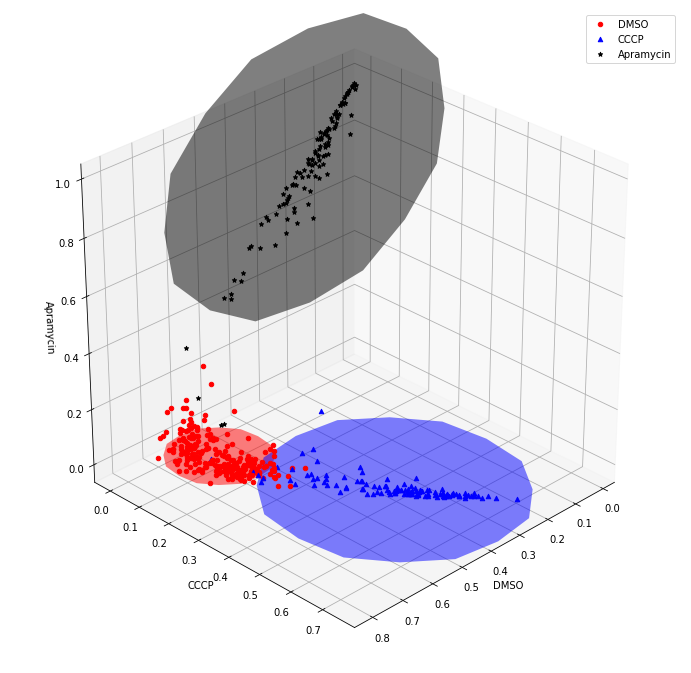

In [79]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

n = 96
for i in range(0, len(alldrug_pd.iloc[idx_dmso].values.tolist())):
    for c, m, in [('r', 'o')]:
        ax.scatter(alldrug_pd.iloc[idx_dmso].values.tolist()[i][0], \
                   alldrug_pd.iloc[idx_dmso].values.tolist()[i][1], \
                   alldrug_pd.iloc[idx_dmso].values.tolist()[i][2], zdir=dmso,c=c,marker =m , label="DMSO" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[idx_cccp].values.tolist())):
    for c, m, in [('b', '^')]:
        ax.scatter(alldrug_pd.iloc[idx_cccp].values.tolist()[i][0], \
                   alldrug_pd.iloc[idx_cccp].values.tolist()[i][1], \
                   alldrug_pd.iloc[idx_cccp].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="CCCP" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[idx_apramycin].values.tolist())):
    for c, m, in [('k', '*')]:
        ax.scatter(alldrug_pd.iloc[idx_apramycin].values.tolist()[i][0], \
                   alldrug_pd.iloc[idx_apramycin].values.tolist()[i][1], \
                   alldrug_pd.iloc[idx_apramycin].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="Apramycin" if i == 0 else "")

#For DMSO
circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

#For CCCP
circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

#For Apramycin
circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
plt.legend()
ax.view_init(30,45)
plt.draw()
plt.show()

## Drug Test Plate Predictions - Plate 13

In [80]:
df_plate_test = pd.read_csv('13plate_TEST_WELL.csv')

In [86]:
df_plate_test = pd.read_csv('13plate_TEST_WELL.csv')
g = globals()
for i in range(1,97):
    label_array = '13_labels_{0}'.format(i)
    trace_array = '13_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    

In [87]:
confidence_list = []
for i in range(1,97):

    g['13_predictions_{0}'.format(i)] = []
    g['13_predictions_{0}'.format(i)] = model.predict([g['13_trace_{0}'.format(i)]])
    
    g['13_plabels_{0}'.format(i)] = np.argmax( g['13_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.6780303  0.08635361 0.23304811 0.0025682 ]


[0.712977   0.09300341 0.19204736 0.00197238]


[0.6780958  0.08279072 0.23396102 0.00515242]


[0.7334221  0.09417394 0.167963   0.00444076]


[0.6833983  0.07853508 0.23566285 0.0024041 ]


[0.73229116 0.12861928 0.13706878 0.00202098]


[0.72138816 0.08536718 0.1910012  0.00224289]


[0.7043761  0.07943358 0.21368174 0.00250856]


[0.6820449  0.09526039 0.21933942 0.00335534]


[0.6225692  0.06787701 0.2720174  0.03753624]


[0.6895928  0.07766107 0.22988226 0.00286408]


[0.51795864 0.39634973 0.08478301 0.00090842]


[0.6932415  0.08315845 0.22141443 0.00218582]


[0.71033776 0.07643016 0.21086355 0.00236878]


[0.70916224 0.09139618 0.19312435 0.00631725]


[0.7263868  0.08140022 0.18892337 0.00328933]


[0.7188565  0.07727682 0.20084201 0.00302475]


[0.71829206 0.08444424 0.19469598 0.00256745]


[0.67950165 0.08871507 0.2290185  0.00276495]


[0.73514163 0.10622704 0.15605073 0.00258079]


[0.7241529  0.0980722  0.17484123 0.0029

In [88]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

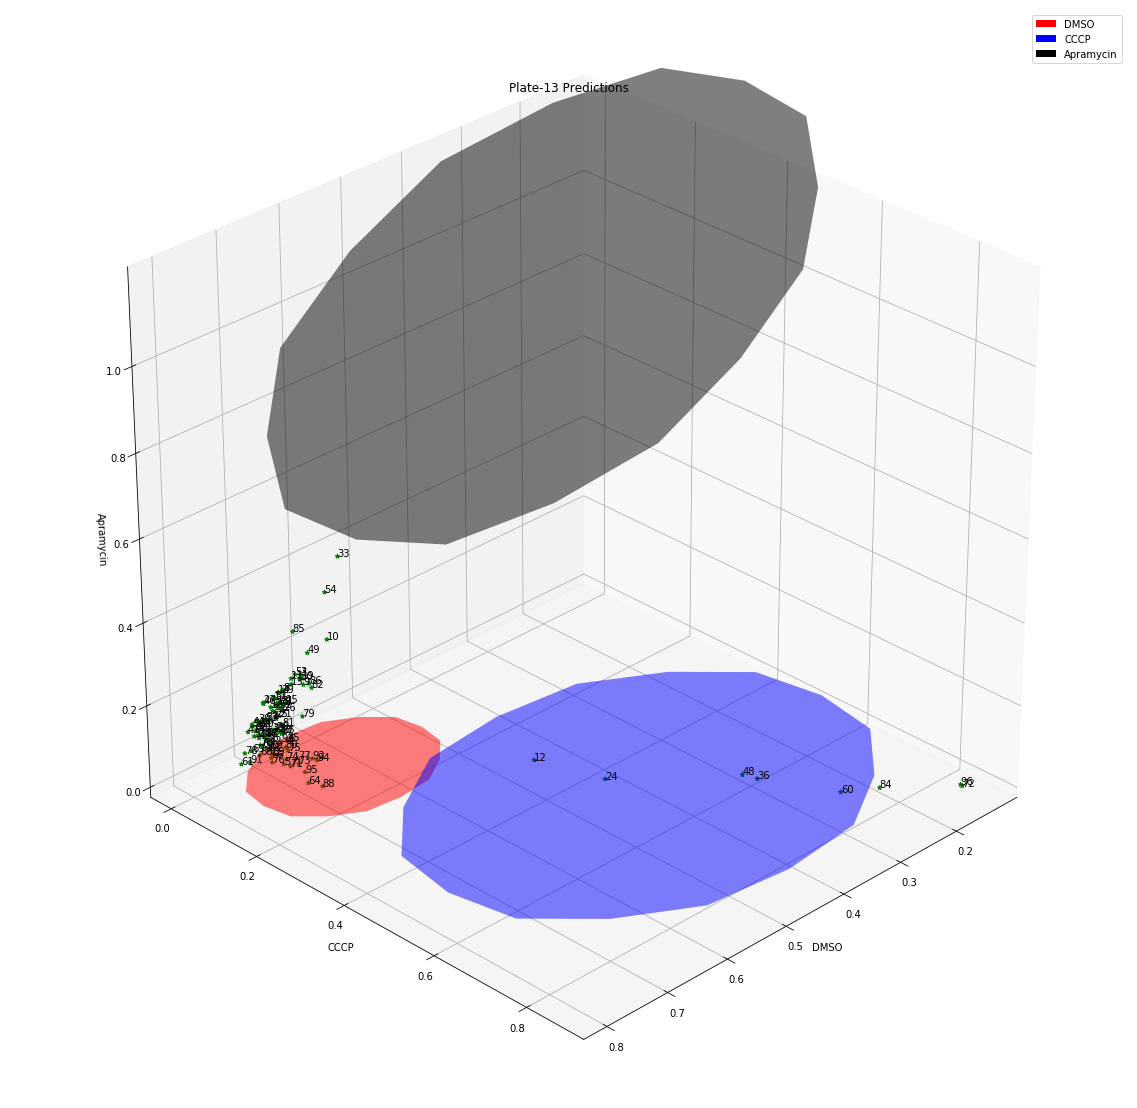

In [93]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

#For DMSO
circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

#For CCCP
circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

#For Apramycin
circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
classes = ['DMSO','CCCP','Apramycin']
class_colours = ['r','b','k']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13 Predictions")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

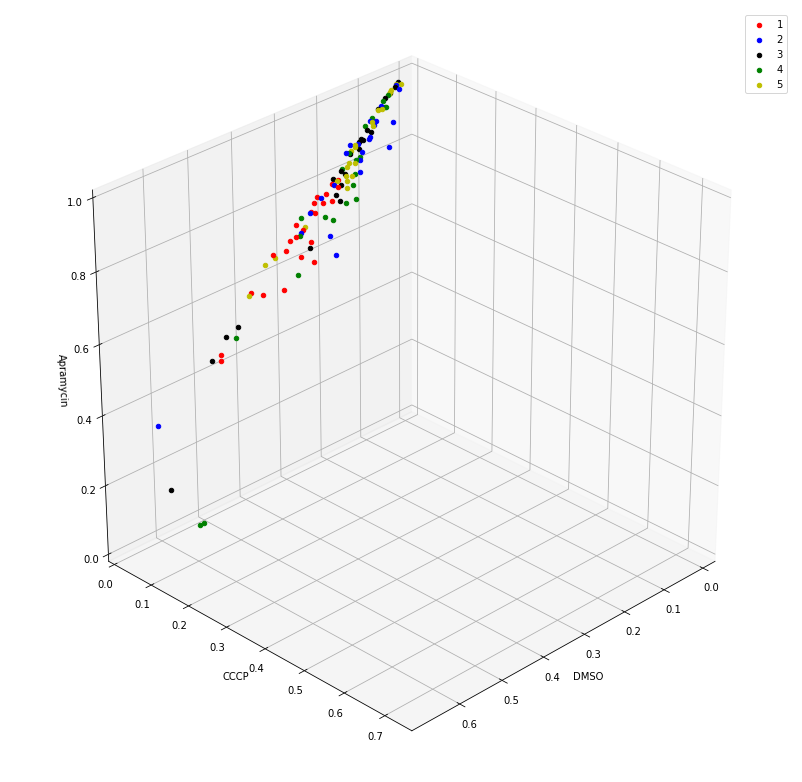

In [100]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

IDX = idx_apramycin #change this to idx_dmso, idx_cccp, idx_apramycin

for i in range(0, len(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.where(np.less_equal(IDX,95))).tolist()[0]]].values.tolist())):
    for c, m, in [('r', 'o')]:
        ax.scatter(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.where(np.less_equal(IDX,95))).tolist()[0]]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.where(np.less_equal(IDX,95))).tolist()[0]]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.where(np.less_equal(IDX,95))).tolist()[0]]].values.tolist()[i][2], zdir=dmso,c=c,marker =m , label="1" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(IDX,95)), np.where(np.less_equal(IDX,192))))].values.tolist())):
    for c, m, in [('b', 'o')]:
        ax.scatter(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,95)), np.where(np.less_equal(IDX,192)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,95)), np.where(np.less_equal(IDX,192)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,95)), np.where(np.less_equal(IDX,192)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="2" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(IDX,192)), np.where(np.less_equal(IDX,288))))].values.tolist())):
    for c, m, in [('k', 'o')]:
        ax.scatter(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,192)), np.where(np.less_equal(IDX,288)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,192)), np.where(np.less_equal(IDX,288)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,192)), np.where(np.less_equal(IDX,288)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="3" if i == 0 else "")
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(IDX,288)), np.where(np.less_equal(IDX,384))))].values.tolist())):
    for c, m, in [('g', 'o')]:
        ax.scatter(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,288)), np.where(np.less_equal(IDX,384)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,288)), np.where(np.less_equal(IDX,384)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,288)), np.where(np.less_equal(IDX,384)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="4" if i == 0 else "")

for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(IDX,384)), np.where(np.less_equal(IDX,480))))].values.tolist())):
    for c, m, in [('y', 'o')]:
        ax.scatter(alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,384)), np.where(np.less_equal(IDX,480)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,384)), np.where(np.less_equal(IDX,480)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[IDX[i] for i in np.asarray(np.intersect1d(np.where(np.greater(IDX,384)), np.where(np.less_equal(IDX,480)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="5" if i == 0 else "")


# ** FOR DMSO WELLS ** 
# Mean - DMSO: 0.6991190530923235, CCCP: 0.20699501444562143, Apramycin: 0.09339410310783305, 
# Std - DMSO: 0.04683912796608349, CCCP: 0.055512401471291474, Apramycin: 0.03386039562612484 

# ** FOR CCCP WELLS ** 
# Mean - DMSO: 0.5542978411462126, CCCP: 0.3955226489225355, Apramycin: 0.049859109780743344, 
# Std - DMSO: 0.07183888806359065, CCCP: 0.07486616201856998, Apramycin: 0.020303023381895068 

# ** FOR APRA WELLS ** 
# Mean - DMSO: 0.276476414858276, CCCP: 0.038726652530618966, Apramycin: 0.6780032304107634, 
# Std - DMSO: 0.12987083564836646, CCCP: 0.03910118292202916, Apramycin: 0.1546627673926802 

# #For DMSO
# circle = Circle((0.6991190530923235,0.20699501444562143),0.04683912796608349*3,alpha = .3, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09339410310783305,zdir="z")

# #For CCCP
# circle = Circle((0.5542978411462126,0.3955226489225355),0.07486616201856998*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.049859109780743344,zdir="z")

# #For Apramycin
# circle = Circle((0.276476414858276,0.6780032304107634),0.1546627673926802*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.038726652530618966,zdir="y")

ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')

ax.set_zlim3d(0,1)
ax.set_ylim3d(0,0.75)

plt.legend()
ax.view_init(30,45)
plt.draw()
plt.show()

## 70_15_15 ratio data - Total 100k

In [163]:
df1_tr = pd.read_csv('data_70_15_15_TRAIN.csv')
df1_val = pd.read_csv('data_70_15_15_VAL.csv')
df1_test = pd.read_csv('data_70_15_15_TEST.csv')

In [134]:
np.asarray(np.where(df1_tr.iloc[:,0]==2)).shape

(1, 10500)

In [164]:
#Train set 
X_train = df1_tr.iloc[:,2:452].values
y_train = df1_tr.iloc[:,0].values

#Val set
X_val = df1_val.iloc[:,2:452].values
y_val = df1_val.iloc[:,0].values

#Test set
X_test = df1_test.iloc[:,2:452].values
y_test = df1_test.iloc[:,0].values

In [129]:
X_train = X_train.reshape(X_train.shape[0],1, 450)
X_test = X_test.reshape(X_test.shape[0], 1, 450)
X_val = X_val.reshape(X_val.shape[0],1, 450)

y_val = np_utils.to_categorical(y_val, 4)
y_test = np_utils.to_categorical(y_test, 4)
y_train = np_utils.to_categorical(y_train, 4)

Train on 70648 samples, validate on 15139 samples
Epoch 1/27
70648/70648 [==============================] - 1032s 15ms/step - loss: 0.5886 - acc: 0.7596 - val_loss: 0.7345 - val_acc: 0.7111

Epoch 00001: val_acc improved from -inf to 0.71114, saving model to model_lstm_70_15_15-01--0.71.hdf5
Epoch 2/27
70648/70648 [==============================] - 1029s 15ms/step - loss: 0.5550 - acc: 0.7752 - val_loss: 1.4102 - val_acc: 0.4576

Epoch 00002: val_acc did not improve from 0.71114
Epoch 3/27
70648/70648 [==============================] - 1029s 15ms/step - loss: 0.5423 - acc: 0.7799 - val_loss: 0.9609 - val_acc: 0.7162

Epoch 00003: val_acc improved from 0.71114 to 0.71616, saving model to model_lstm_70_15_15-03--0.72.hdf5
Epoch 4/27
70648/70648 [==============================] - 1031s 15ms/step - loss: 0.5336 - acc: 0.7845 - val_loss: 0.5985 - val_acc: 0.7536

Epoch 00004: val_acc improved from 0.71616 to 0.75362, saving model to model_lstm_70_15_15-04--0.75.hdf5
Epoch 5/27
70648/70648 [

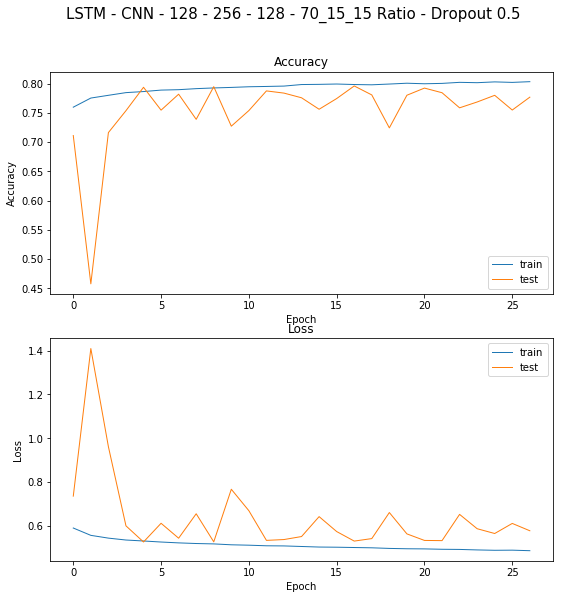

In [141]:

MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(128)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model

x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "model_lstm_70_15_15-{epoch:02d}--{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',verbose=1,save_best_only=True,mode='max')
cb = [checkpoint]
h = model.fit(X_train,y_train,
                             epochs = 27,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 128 - 256 - 128 - 70_15_15 Ratio - Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

#model.save('timeseries_lstm_cnn_70_15_15.h5')
#return accuracy

## 20_40_40 ratio data - Total 100k

Train on 70648 samples, validate on 15139 samples
Epoch 1/27
70648/70648 [==============================] - 1021s 14ms/step - loss: 0.5914 - acc: 0.7573 - val_loss: 0.5626 - val_acc: 0.7786

Epoch 00001: val_acc improved from -inf to 0.77859, saving model to model_lstm_20_40_40-01--0.779.hdf5
Epoch 2/27
70648/70648 [==============================] - 1020s 14ms/step - loss: 0.5565 - acc: 0.7755 - val_loss: 0.8245 - val_acc: 0.7028

Epoch 00002: val_acc did not improve from 0.77859
Epoch 3/27
70648/70648 [==============================] - 1021s 14ms/step - loss: 0.5423 - acc: 0.7807 - val_loss: 0.5375 - val_acc: 0.7928

Epoch 00003: val_acc improved from 0.77859 to 0.79279, saving model to model_lstm_20_40_40-03--0.793.hdf5
Epoch 4/27
70648/70648 [==============================] - 1021s 14ms/step - loss: 0.5338 - acc: 0.7854 - val_loss: 0.7834 - val_acc: 0.7172

Epoch 00004: val_acc did not improve from 0.79279
Epoch 5/27
70648/70648 [==============================] - 1021s 14ms/step - l

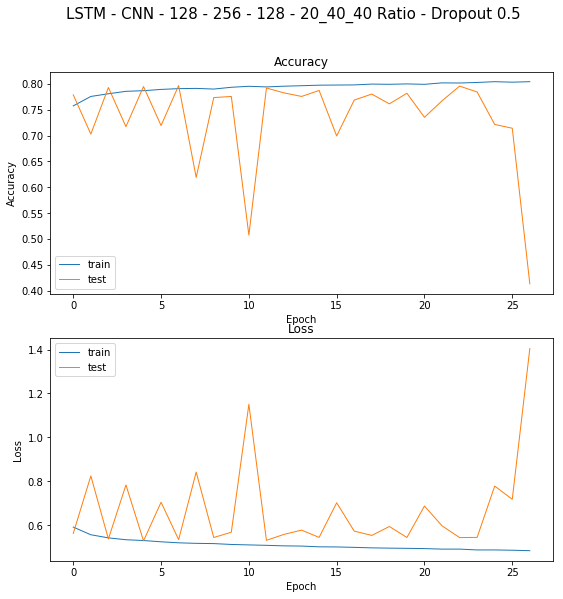

In [142]:
df1_tr = pd.read_csv('data_20_40_40_TRAIN.csv')
df1_val = pd.read_csv('data_20_40_40_VAL.csv')
df1_test = pd.read_csv('data_20_40_40_TEST.csv')
#Train set 
X_train = df1_tr.iloc[:,2:452].values
y_train = df1_tr.iloc[:,0].values

#Val set
X_val = df1_val.iloc[:,2:452].values
y_val = df1_val.iloc[:,0].values

#Test set
X_test = df1_test.iloc[:,2:452].values
y_test = df1_test.iloc[:,0].values


X_train = X_train.reshape(X_train.shape[0],1, 450)
X_test = X_test.reshape(X_test.shape[0], 1, 450)
X_val = X_val.reshape(X_val.shape[0],1, 450)

y_val = np_utils.to_categorical(y_val, 4)
y_test = np_utils.to_categorical(y_test, 4)
y_train = np_utils.to_categorical(y_train, 4)


MAX_SEQUENCE_LENGTH = 450
NB_CLASS = 4

def generate_model():
    ip = Input(shape=(1, MAX_SEQUENCE_LENGTH))

    x = LSTM(128)(ip)
    x = Dropout(0.5)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128,10,padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128,10, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(ip, out)

    #model.summary()

    # add load model code here to fine-tune

    return model

x = X_train
y = y_train
model = generate_model()
optm = Adam(lr=1e-3)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "model_lstm_20_40_40-{epoch:02d}--{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',verbose=1,save_best_only=True,mode='max')
cb = [checkpoint]
h = model.fit(X_train,y_train,
                             epochs = 27,
                             batch_size=32,
                             verbose = 1,
                             validation_data = (X_val,y_val),
                             callbacks = cb)
    # 10. Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('LSTM - CNN - 128 - 256 - 128 - 20_40_40 Ratio - Dropout 0.5', fontsize = 15)
plt.subplot(211)  
plt.plot(h.history['acc'], linewidth = 1.0)  
plt.plot(h.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h.history['loss'], linewidth = 1.0)  
plt.plot(h.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

model.save('timeseries_lstm_cnn_20_40_40.h5')
#return accuracy

## 13 Plate of split data

In [229]:
df_plate_test = pd.read_csv('13plate_TEST_WELL.csv')
g = globals()
for i in range(1,97):
    label_array = '13_labels_{0}'.format(i)
    trace_array = '13_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    

In [157]:
model = load_model('model_lstm_70_15_15-17--0.80.hdf5')

In [158]:
confidence_list = []
for i in range(1,97):

    g['13_predictions_{0}'.format(i)] = []
    g['13_predictions_{0}'.format(i)] = model.predict([g['13_trace_{0}'.format(i)]])
    
    g['13_plabels_{0}'.format(i)] = np.argmax( g['13_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.43118602 0.18390962 0.35719925 0.02770505]


[0.43970144 0.19867608 0.33427218 0.02735048]


[0.40037397 0.17184505 0.39019433 0.03758636]


[0.47381204 0.19765466 0.29844978 0.03008363]


[0.4136148  0.19134395 0.36842635 0.0266148 ]


[0.4754628  0.2681807  0.22520731 0.03114905]


[0.4451749  0.19523123 0.3306323  0.02896181]


[0.41911682 0.1666146  0.3759855  0.03828311]


[0.4012883  0.18900175 0.37533608 0.03437371]


[0.30658174 0.16031966 0.47583875 0.05725973]


[0.40898383 0.18153194 0.37770915 0.0317753 ]


[0.27816632 0.5914282  0.12280497 0.00760063]


[0.4337291  0.18796438 0.3511036  0.02720284]


[0.44305238 0.17358705 0.3554255  0.02793467]


[0.4201031  0.18936042 0.35270587 0.03783069]


[0.4410449  0.18082453 0.34489393 0.03323691]


[0.43525168 0.17589974 0.35629886 0.03254958]


[0.44860005 0.18668014 0.33050132 0.03421854]


[0.39121127 0.17305514 0.39732358 0.03841007]


[0.47600222 0.2201918  0.27861318 0.02519302]


[0.4569035  0.20698263 0.3072388  0.0288

In [159]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

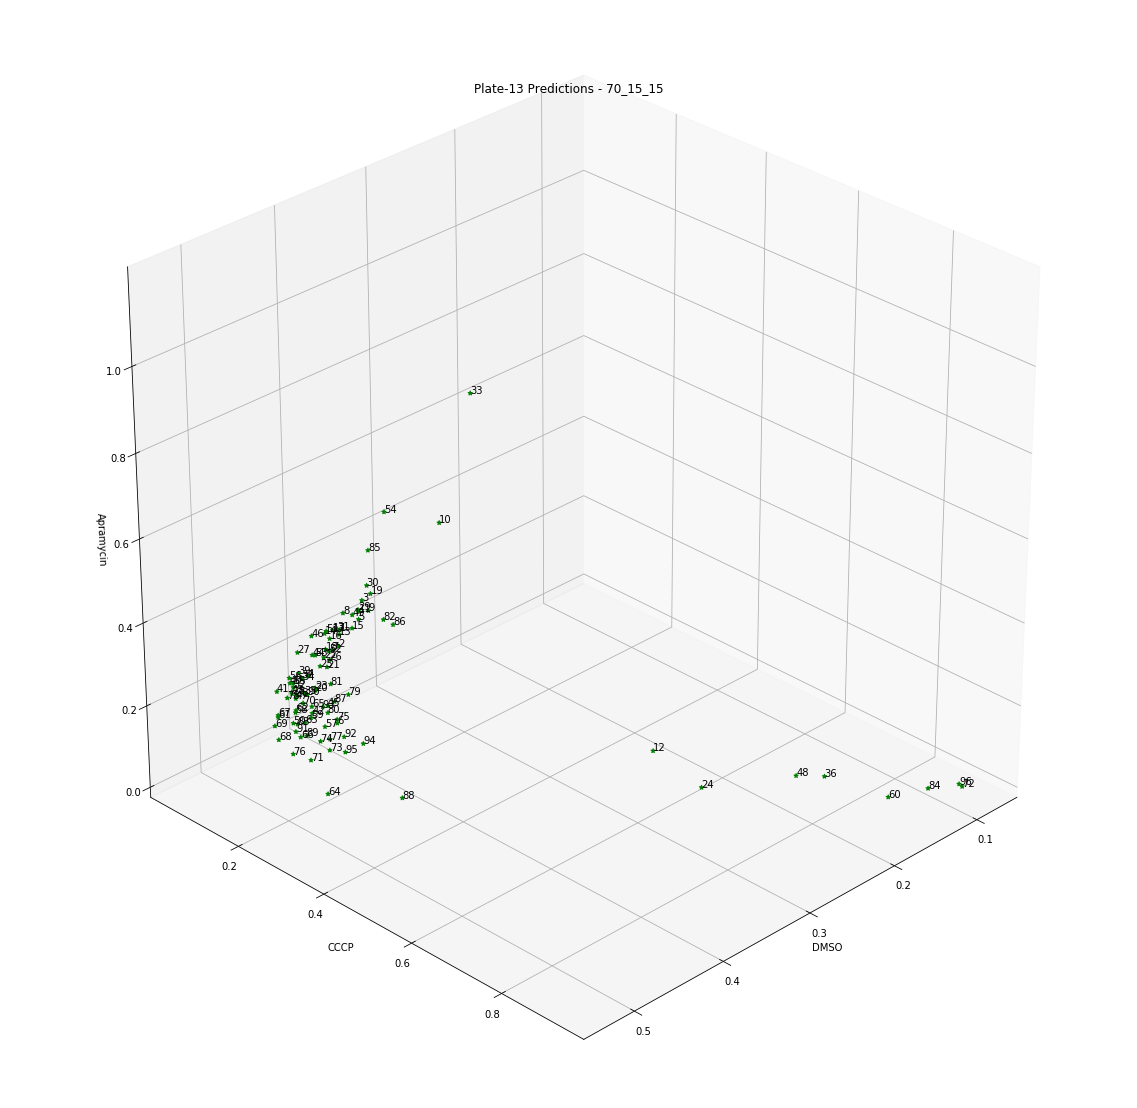

In [160]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13 Predictions - 70_15_15")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

In [151]:
# 20_40_40 split

In [152]:
model = load_model('model_lstm_20_40_40-07--0.797.hdf5')

In [154]:
confidence_list = []
for i in range(1,97):

    g['13_predictions_{0}'.format(i)] = []
    g['13_predictions_{0}'.format(i)] = model.predict([g['13_trace_{0}'.format(i)]])
    
    g['13_plabels_{0}'.format(i)] = np.argmax( g['13_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.48014006 0.13516347 0.36829236 0.01640407]


[0.47444755 0.14418496 0.36694622 0.01442123]


[0.43257838 0.12375315 0.42275605 0.02091224]


[0.5021794  0.14088401 0.3424299  0.01450638]


[0.45203552 0.14120205 0.39264202 0.01412047]


[0.52204806 0.19106732 0.27143145 0.01545297]


[0.4850204  0.13496566 0.36370498 0.0163091 ]


[0.45374188 0.11286499 0.41642407 0.01696903]


[0.42776895 0.13557024 0.4175257  0.01913512]


[0.36701646 0.09415627 0.514371   0.02445658]


[0.44521934 0.12837024 0.41026032 0.01614977]


[0.3375196  0.50638473 0.15272953 0.00336614]


[0.47198996 0.13944261 0.37312016 0.01544728]


[0.47843283 0.12196356 0.3848439  0.01475967]


[0.4571401  0.13068314 0.39267445 0.01950252]


[0.47243932 0.12329293 0.3884101  0.01585777]


[0.45903602 0.11843037 0.4072427  0.01529087]


[0.47557423 0.12925777 0.3790425  0.01612586]


[0.40472236 0.11928063 0.458205   0.017792  ]


[0.5073335  0.15135099 0.32920095 0.01211474]


[0.49278522 0.14428955 0.34827796 0.0146

In [155]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

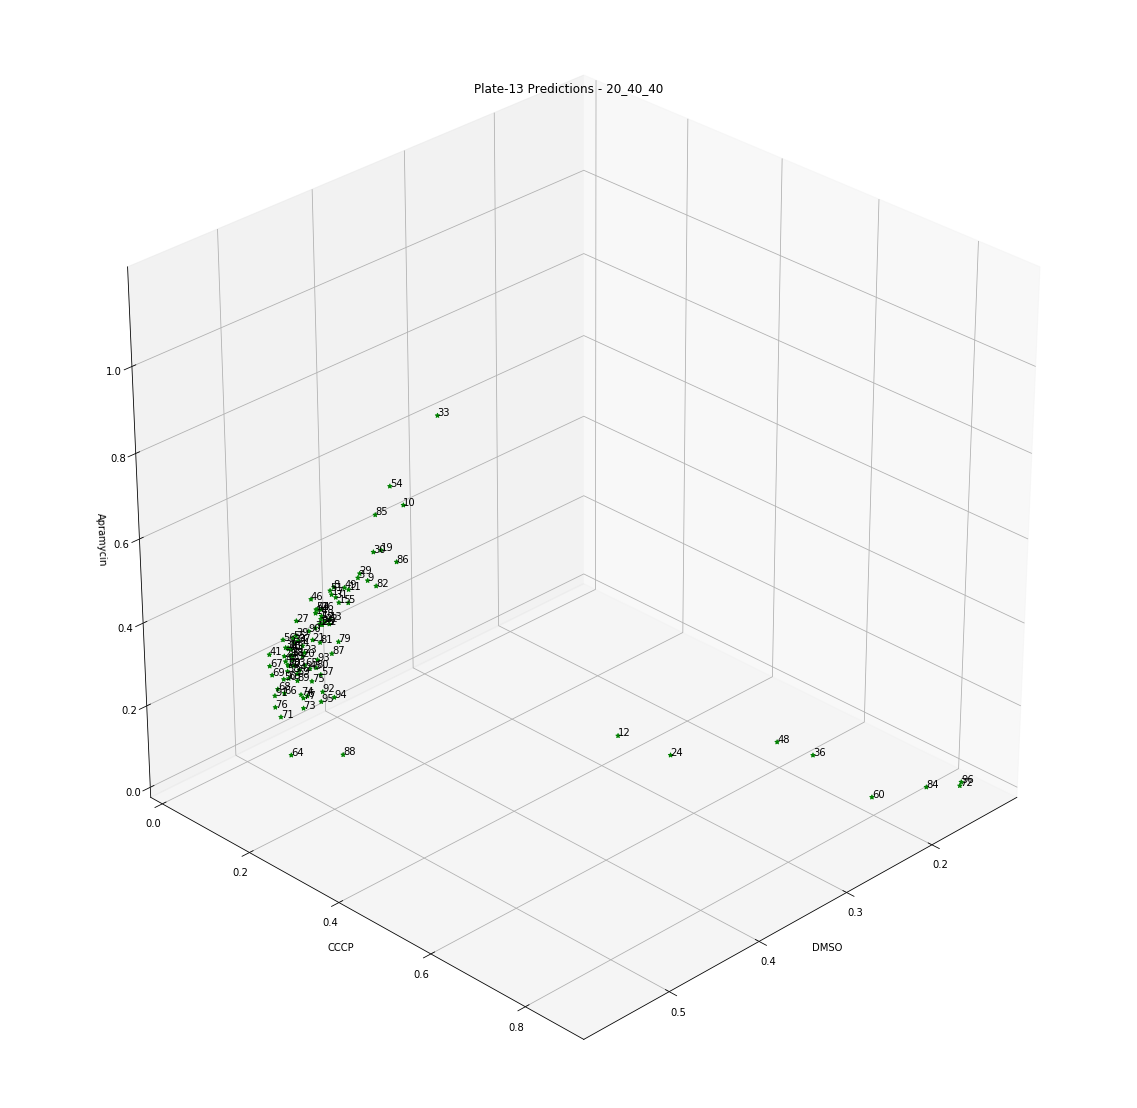

In [156]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13 Predictions - 20_40_40")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

In [178]:
df1_val = pd.read_csv('data_70_15_15_VAL.csv')


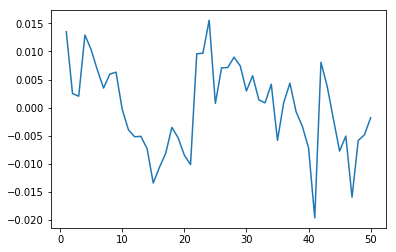

In [190]:
#downsampled
plt.plot(range(1,51),signal.resample(df1_val.iloc[1,2:452],50))
plt.show()

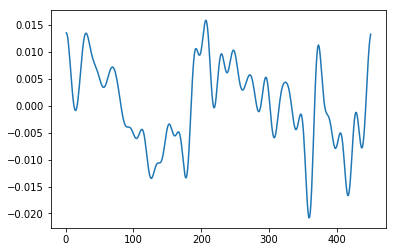

In [192]:
#Upsampled after downsampling
plt.plot(range(1,451),signal.resample(signal.resample(df1_val.iloc[1,2:452],50),450))
plt.show()

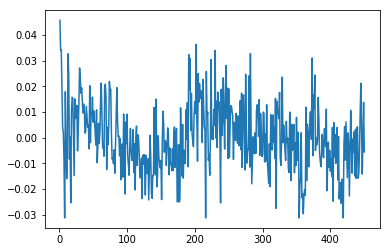

In [187]:
#original trace
plt.plot(range(1,451),df1_val.iloc[1,2:452])

## conc_data_20180718 data

In [ ]:
#Way to drop the extra columns
df_plate_test.drop(columns=df_plate_test.columns[451:601])
#SLOW Method
for i in range(0,103134):
    df_plate_test.iloc[i,1:451] = signal.resample(df_plate_test.iloc[i,1:601],450)
    if(i%100==0):
        print(i)
df_plate_test = df_plate_test.drop(columns=df_plate_test.columns[451:601])

In [2]:
df_plate_test = pd.read_csv('conc_data_1_103k_TEST_WELL.csv')

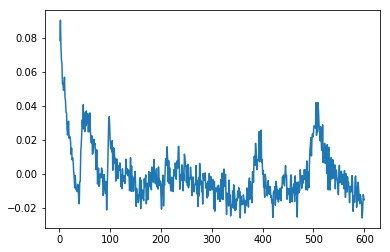

In [306]:
#check trace data
plt.plot(range(1,601),df_plate_test.iloc[2,1:601])

In [3]:
df_plate_test.iloc[:,1:451] = np.reshape(np.append(np.array([]),signal.resample(df_plate_test.iloc[:,1:601].values,450,axis=1)),(103134,450))
df_plate_test = df_plate_test.drop(columns=df_plate_test.columns[451:601])

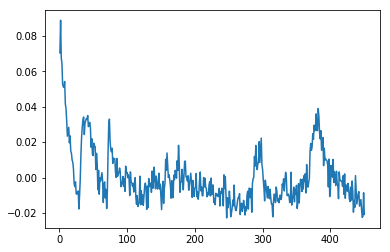

In [445]:
plt.plot(range(1,451),df_plate_test.iloc[2,1:451])

In [4]:
model = load_model('model_lstm_70_15_15-17--0.80.hdf5')

In [7]:
g = globals()
confidence_list = []

for i in range(1,97):
    label_array = 'labels_{0}y'.format(i)
    trace_array = 'trace_{0}y'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    
    g['103k_predictions2_{0}'.format(i)] = []
    g['103k_predictions2_{0}'.format(i)] = model.predict([g['trace_{0}y'.format(i)]])
    
    g['103k_plabels1_{0}'.format(i)] = np.argmax( g['103k_predictions2_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['103k_predictions2_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['103k_predictions2_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.3454921  0.29489887 0.33593455 0.02367439]


[0.41537943 0.35814235 0.21532844 0.01114977]


[0.40277937 0.3169892  0.26261535 0.01761629]


[0.31878448 0.57239383 0.1024651  0.00635702]


[0.4188762  0.39338562 0.1771187  0.01061897]


[0.47395012 0.32957974 0.18497449 0.0114958 ]


[0.40904468 0.32888603 0.24770768 0.0143615 ]


[0.37930557 0.2975191  0.30688664 0.01628885]


[0.3793498  0.31946933 0.28504825 0.01613278]


[0.41658878 0.30380917 0.26640368 0.01319866]


[0.40119517 0.3686245  0.21806067 0.01211946]


[0.27223733 0.680369   0.04430584 0.00308821]


[0.41458595 0.4168718  0.16037491 0.00816703]


[0.41439933 0.32363054 0.24953002 0.01244025]


[0.43797827 0.30837548 0.24010704 0.01353923]


[0.38596874 0.31035534 0.28817308 0.01550319]


[0.4056014  0.36941165 0.21004821 0.01493858]


[0.40149984 0.33665964 0.24724399 0.01459683]


[0.4267101 0.3073115 0.2504989 0.0154797]


[0.39583293 0.3410272  0.24963015 0.01351017]


[0.40524024 0.3467316  0.23429805 0.01372987

In [8]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

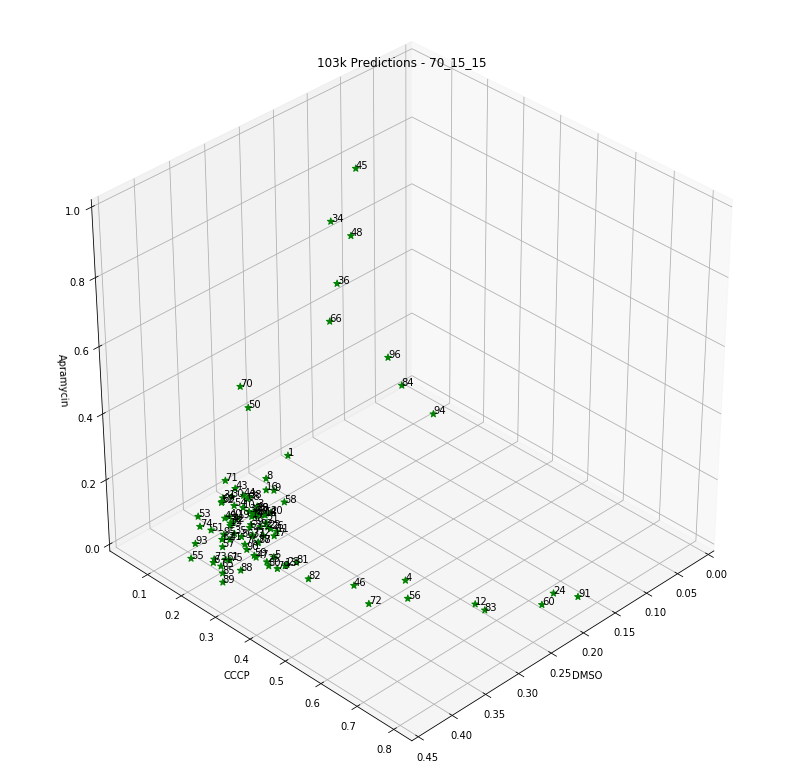

In [9]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(50))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.text(0.3454921, 0.29489887, 0.33593455,'HIII')  0.274165   0.37592232 0.34013793 0.00977458
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1)
ax.set_xlim3d(0,.45)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(35,45)
plt.title("103k Predictions - 70_15_15")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

In [13]:
alldrug_pd = pd.DataFrame(data = confidence_list)
alldrug_pd = pd.DataFrame(data = alldrug_pd.drop(columns = 3))
dmso_pd = pd.DataFrame(data= dmso)
cccp_pd = pd.DataFrame(data = cccp)
apra_pd = pd.DataFrame(data = apramycin)
#Confidence for all DMSO, CCCP, Apramycin Wells
print('** FOR DMSO WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(apra_pd[0].iloc[idx_dmso].values),\
                                                                np.std(dmso_pd[0].iloc[idx_dmso].values), \
                                                                np.std(cccp_pd[0].iloc[idx_dmso].values), \
                                                                np.std(apra_pd[0].iloc[idx_dmso].values)))

print('\n** FOR CCCP WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(apra_pd[0].iloc[idx_cccp].values),\
                                                                np.std(dmso_pd[0].iloc[idx_cccp].values), \
                                                                np.std(cccp_pd[0].iloc[idx_cccp].values), \
                                                                np.std(apra_pd[0].iloc[idx_cccp].values)))

print('\n** FOR APRA WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(apra_pd[0].iloc[idx_apramycin].values),\
                                                                np.std(dmso_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(cccp_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(apra_pd[0].iloc[idx_apramycin].values)))

** FOR DMSO WELLS ** 
Mean - DMSO: 0.4238109943958429, CCCP: 0.3268952178649413, Apramycin: 0.23329104616855964, 
Std - DMSO: 0.028499520698153882, CCCP: 0.04732817987069607, Apramycin: 0.05341519627824109 

** FOR CCCP WELLS ** 
Mean - DMSO: 0.2783798724412918, CCCP: 0.6593386133511862, Apramycin: 0.058373673922485776, 
Std - DMSO: 0.06695689956969543, CCCP: 0.09602453261995059, Apramycin: 0.03070052889761894 

** FOR APRA WELLS ** 
Mean - DMSO: 0.20324516544739404, CCCP: 0.2175670506225692, Apramycin: 0.5448097553518083, 
Std - DMSO: 0.07049091992845888, CCCP: 0.12311864380065284, Apramycin: 0.15653127231653088 


In [89]:
np.asarray(np.where(np.less_equal(idx_apramycin,96)))[0].ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [69]:
def calcstd(idx,pd,cluster,num):
    
    #pass the indices of just the drugs
    std = [np.std(pd.iloc[idx,0].values), np.std(pd.iloc[idx,1].values), np.std(pd.iloc[idx,2].values) ]
    s = []
    if(cluster=="dmso"):
        mean = np.mean(pd.iloc[idx,0].values)
    elif(cluster=="cccp"):
        mean = np.mean(pd.iloc[idx,1].values)
    elif(cluster=="apramycin"):
        mean = np.mean(pd.iloc[idx,2].values)
        
    for i in range(0,len(idx)):
        s.append(np.divide(np.linalg.norm(pd.iloc[idx,num].values[i] - mean),sum(std)))
    return np.mean(s)

for cluster in ["dmso", "cccp"]:
    print("Apramycin Wells from "+cluster+":  ",calcstd(idx_apramycin, alldrug_pd, cluster, 2))
    
for cluster in ["apramycin", "cccp"]:
    print("DMSO Wells from "+cluster+":  ",calcstd(idx_dmso, alldrug_pd, cluster, 0))
    
for cluster in ["dmso", "apramycin"]:
    print("CCCP Wells from "+cluster+":  ",calcstd(idx_cccp, alldrug_pd, cluster,1))

In [17]:
dmso_mean = [0.4238109943958429, 0.3268952178649413, 0.23329104616855964 ]
dmso_std = [0.028499520698153882, 0.04732817987069607, 0.05341519627824109]
#Euclidean distance for all the cccp idx
for i in range(0,9):
    print(np.divide(np.linalg.norm(alldrug_pd.iloc[idx_cccp].values[i] - dmso_mean),sum(dmso_std)))

2.3006877934020475
3.3156564395297874
4.076949518647095
1.8184087981035086
2.5297366982693026
4.058754859280917
2.1980020117675863
3.4860475976038656
4.3873132674899775


## CCCP - 3.1301729982327

In [15]:
for i in range(0,9):
    print(np.divide(np.linalg.norm(alldrug_pd.iloc[idx_apramycin].values[i] - dmso_mean),sum(dmso_std)))

0.70320731860421
4.626152923476635
3.618786481891126
5.426113802601028
4.363251428557162
3.0427238391651605
2.251027712677983
2.1728546404896183
2.543130746816637


## Apra - 3.1941387660311

In [18]:
model = load_model('model_lstm_20_40_40-07--0.797.hdf5')

In [19]:
g = globals()
confidence_list = []
for i in range(1,97):
    label_array = 'labels_{0}y'.format(i)
    trace_array = '103k_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    
    g['103k_predict_{0}'.format(i)] = []
    g['103k_predict_{0}'.format(i)] = model.predict([g['103k_trace_{0}'.format(i)]])
    
    g['103k_plabels_{0}'.format(i)] = np.argmax( g['103k_predict_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['103k_predict_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['103k_predict_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.4154324  0.24187542 0.32819024 0.01450214]


[0.4771691  0.30033585 0.21646094 0.00603408]


[0.46512058 0.25668302 0.26933077 0.00886602]


[0.378989   0.49847937 0.11974988 0.00278152]


[0.48067626 0.32705334 0.18706496 0.00520582]


[0.5354044  0.27033043 0.18907188 0.00519346]


[0.46911076 0.27334487 0.25052896 0.00701548]


[0.43716398 0.251837   0.3023222  0.00867643]


[0.43595663 0.26823848 0.28885224 0.00695278]


[0.475454   0.25195217 0.26601815 0.00657594]


[0.4633465  0.3038788  0.2271027  0.00567192]


[0.33641872 0.59927803 0.0630583  0.00124538]


[0.47459483 0.34342778 0.17828701 0.00369017]


[0.4777855  0.26403165 0.25227538 0.00590775]


[0.49375033 0.24852249 0.25121436 0.00651288]


[0.4483952  0.25609678 0.28787273 0.00763523]


[0.46680266 0.30203134 0.22490864 0.00625741]


[0.4612117  0.2760705  0.25564766 0.00707008]


[0.48558998 0.2512825  0.25559756 0.00753006]


[0.45976922 0.28453064 0.24921289 0.00648736]


[0.46707916 0.28761598 0.23906507 0.0062

In [20]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

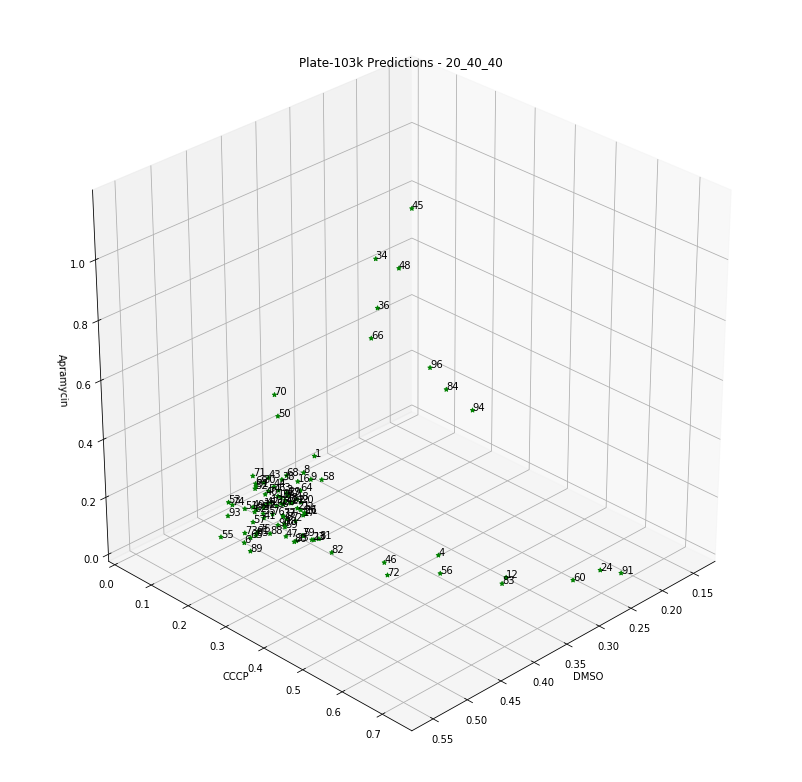

In [21]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-103k Predictions - 20_40_40")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

In [25]:
# ToDo- (-1) in all list idx
well_nos = np.array(range(1,97))
well_nos = well_nos-1
idx_cccp = np.array([4,12,24,46,56,60,72,83, 91])
idx_cccp = idx_cccp - 1
idx_apramycin = np.array([8, 34, 36, 45, 48, 66, 84, 94, 96])
idx_apramycin = idx_apramycin - 1

In [29]:
#returns values which are in first argument and not in 2nd
idx_dmso = np.setdiff1d(well_nos, np.union1d(idx_cccp,idx_apramycin)).tolist()
idx_cccp = idx_cccp.tolist()
idx_apramycin = idx_apramycin.tolist()

<built-in method var of numpy.ndarray object at 0x000001B77D9CF080>
[ 4 12 24 46 56 60 72 83 91]
[ 8 34 36 45 48 66 84 94 96]


In [22]:
alldrug_pd = pd.DataFrame(data = confidence_list)
alldrug_pd = pd.DataFrame(data = alldrug_pd.drop(columns = 3))
dmso_pd = pd.DataFrame(data= dmso)
cccp_pd = pd.DataFrame(data = cccp)
apra_pd = pd.DataFrame(data = apramycin)
#Confidence for all DMSO, CCCP, Apramycin Wells
print('** FOR DMSO WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(apra_pd[0].iloc[idx_dmso].values),\
                                                                np.std(dmso_pd[0].iloc[idx_dmso].values), \
                                                                np.std(cccp_pd[0].iloc[idx_dmso].values), \
                                                                np.std(apra_pd[0].iloc[idx_dmso].values)))

print('\n** FOR CCCP WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(apra_pd[0].iloc[idx_cccp].values),\
                                                                np.std(dmso_pd[0].iloc[idx_cccp].values), \
                                                                np.std(cccp_pd[0].iloc[idx_cccp].values), \
                                                                np.std(apra_pd[0].iloc[idx_cccp].values)))

print('\n** FOR APRA WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(apra_pd[0].iloc[idx_apramycin].values),\
                                                                np.std(dmso_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(cccp_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(apra_pd[0].iloc[idx_apramycin].values)))

** FOR DMSO WELLS ** 
Mean - DMSO: 0.48286408529831815, CCCP: 0.2643037196726371, Apramycin: 0.24522270415073785, 
Std - DMSO: 0.02731697085572653, CCCP: 0.041073151596083005, Apramycin: 0.04723296850366445 

** FOR CCCP WELLS ** 
Mean - DMSO: 0.34235504435168373, CCCP: 0.5810305741098192, Apramycin: 0.0750389194322957, 
Std - DMSO: 0.07002839715962256, CCCP: 0.0969775986008271, Apramycin: 0.02961478333494492 

** FOR APRA WELLS ** 
Mean - DMSO: 0.2547117835945553, CCCP: 0.18589627080493504, Apramycin: 0.5317804449134402, 
Std - DMSO: 0.07454403217646656, CCCP: 0.10818221316636634, Apramycin: 0.14490013850215866 


In [23]:
dmso_mean = [0.48286408529831815,0.2643037196726371, 0.24522270415073785]
dmso_std = [0.02731697085572653, 0.041073151596083005, 0.04723296850366445]
for i in range(0,9):
    print(np.divide(np.linalg.norm(alldrug_pd.iloc[idx_cccp].values[i] - dmso_mean),sum(dmso_std)))

2.46713038960832
3.5326677147793757
4.553666661597072
1.9727256724082534
2.7357328430077015
4.345678490407101
2.201847445865904
3.568723418205702
4.837287486257122


## 3.3572733469041

In [24]:
for i in range(0,9):
    print(np.divide(np.linalg.norm(alldrug_pd.iloc[idx_apramycin].values[i] - dmso_mean),sum(dmso_std)))

0.6416606300988016
4.737626095312888
3.750748164569895
5.704707944921617
4.5310996448811425
3.170305285774251
2.527958806737726
2.4840468632702657
2.757964400198797


## 3.3673464261962

In [ ]:
#for versions other than 7.3
dummy = loadmat('C:/Users/Kraljlab/Desktop/BigData_CNN_ImagesModel/labelled_trace_798k_bigdata_with_red.mat')

#for h5py format
with h5py.File('labelled_trace_798k_bigdata_with_red.mat','r+') as file:
    print(file['data']['intensG'])

In [ ]:
dummy = hdf5storage.loadmat('labelled_trace_798k_bigdata_600T_JK')

In [97]:
temp = signal.resample(dummy['data'][0][1][0][0],450)
np.resize(dummy['data'][0][1][0][0],450)
np.put(a=dummy['data'][0][1][0][0],ind=range(0,450),v=temp)


## 383k data calculate test accuracy

In [114]:
df3 = pd.read_csv('data383k_50_50_50_TEST.csv')
X_test = df3.iloc[:,2:452].values
y_test = df3.iloc[:,0].values
X_test = X_test.reshape(X_test.shape[0], 1, 450)
y_test = np_utils.to_categorical(y_test, 4)

In [6]:
model = load_model('model_lstm383k_50_50_50-28--0.700.hdf5')
score = model.evaluate(X_test, y_test, verbose=1)
print('Test accuarcy:', str(score))

predictions = model.predict([X_test])

real_labels = np.argmax(y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

57934/57934 [==============================] - 266s 5ms/step
Test accuarcy: [0.6809194406757044, 0.7022473849558084]
Recognition Rate: 70.2247384955294


## JK's data - 798k downsample

In [106]:
chunksize = 99833 #798664/8
df_jk = pd.DataFrame()
i=0
length = 100
for chunk in pd.read_csv('data_798k_JK.csv', chunksize=chunksize):
    #print(chunk.head(5))
    #print('\n NEXT \n')
    chunk.iloc[:,0:length] = np.reshape(np.append(np.array([]),signal.resample(chunk.iloc[:,0:600].values,length,axis=1)),(99833,length))
    chunk = chunk.drop(columns=chunk.columns[length:1200])
    df_jk = df_jk.append(chunk)
    i+=1
    print(i)

1
2
3
4
5
6
7
8


In [107]:
X, X_t, y, y_t = train_test_split(df_jk.iloc[:,0:(length+2)], df_jk.iloc[:,(length+1)], test_size=0.15, shuffle=True)
X, X_v, y, y_v = train_test_split(X, y, test_size=0.176471)

In [108]:
train_1000_0 = X.iloc[:,X.columns!='well'].iloc[np.asarray(np.where(y==0)).tolist()[0],:].sample(n=1000)
train_1000_1 = X.iloc[:,X.columns!='well'].iloc[np.asarray(np.where(y==1)).tolist()[0],:].sample(n=1000)
train_1000_2 = X.iloc[:,X.columns!='well'].iloc[np.asarray(np.where(y==2)).tolist()[0],:].sample(n=1000)
train_1000_3 = X.iloc[:,X.columns!='well'].iloc[np.asarray(np.where(y==3)).tolist()[0],:].sample(n=1000)
X_train = train_1000_0.append(train_1000_1.append(train_1000_2.append(train_1000_3)))
X_val = X_v.iloc[:,X_v.columns!='well'].sample(n=1000)
X_test = X_t.iloc[:,X_t.columns!='well'].sample(n=1000)

In [109]:
X_val.to_csv('VAL-100down-1k-trace.csv',index= False)
X_train.to_csv('TRAIN-100down-1k-trace.csv',index= False)
X_test.to_csv('TEST-100down-1k-trace.csv',index= False)

## Wavelet Smooth

In [222]:
%matplotlib tk
import pywt
import seaborn
from statsmodels.robust import mad

def waveletSmooth(x, wavelet="db4", level=1, title=None):
    coeff = pywt.wavedec(x,wavelet, mode="per")
    sigma = mad(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i,value=uthresh,mode="soft") for i in coeff[1:])
    y=pywt.waverec(coeff,wavelet,mode="per")
    #f,ax = plt.subplots()
    #plot(x,color="r",alpha=0.5)
    #plot(y,color="b")
    #ax.set_xlim((0,len(y)))
    return y

Using matplotlib backend: TkAgg


In [129]:
df_gc = pd.read_csv("data_306k_GC.csv")

In [194]:
waveletSmooth(df_gc.iloc[428,0:450].values)
plt.style.use('Solarize_Light2')

In [164]:
np.where(df_gc.iloc[:,901]==1)

(array([   428,    429,    430, ..., 305841, 305842, 305843], dtype=int64),)

In [218]:
df_train = pd.read_csv("data383k_50_50_50_TRAIN.csv")
df_train.iloc[:,2:452] = waveletSmooth(df_train.iloc[:,2:452].values.ravel()).reshape(df_train.shape[0],450)
df_test = pd.read_csv("data383k_50_50_50_TEST.csv")
df_test.iloc[:,2:452] = waveletSmooth(df_test.iloc[:,2:452].values.ravel()).reshape(df_test.shape[0],450)
df_val = pd.read_csv("data383k_50_50_50_VAL.csv")
df_val.iloc[:,2:452] = waveletSmooth(df_val.iloc[:,2:452].values.ravel()).reshape(df_val.shape[0],450)

In [227]:
df_val.to_csv('data383k_50_50_50_VAL_Smoothed.csv',index= False)
df_train.to_csv('data383k_50_50_50_TRAIN_Smoothed.csv',index= False)
df_test.to_csv('data383k_50_50_50_TEST_Smoothed.csv',index= False)

## Drug 13 Plate with equal ratio model: 383k - No Smoothing

In [228]:
model = load_model('model_lstm383k_50_50_50-28--0.700.hdf5')

In [232]:
g = globals()
confidence_list = []
for i in range(1,97):
    label_array = 'labels_{0}y'.format(i)
    trace_array = '383k_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    
    g['383k_predict_{0}'.format(i)] = []
    g['383k_predict_{0}'.format(i)] = model.predict([g['13_trace_{0}'.format(i)]])
    
    g['383k_plabels_{0}'.format(i)] = np.argmax( g['383k_predict_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['383k_predict_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['383k_predict_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.38695985 0.18689272 0.39925376 0.02689375]


[0.41752657 0.19129848 0.37180522 0.01936974]


[0.39640415 0.17226791 0.4067084  0.02461944]


[0.4523632  0.17946917 0.3484361  0.01973153]


[0.38176528 0.17712402 0.42078036 0.02033057]


[0.4338006  0.24831024 0.29989395 0.01799517]


[0.42295724 0.17924154 0.38161376 0.01618734]


[0.43992296 0.15237562 0.37870386 0.02899747]


[0.39286092 0.18621755 0.40032    0.02060168]


[0.31156543 0.15651287 0.4861987  0.04572296]


[0.4034082  0.17419375 0.40298933 0.01940883]


[0.31901366 0.50361013 0.1690049  0.00837135]


[0.4107481  0.1676766  0.39982367 0.02175146]


[0.41836777 0.1677985  0.39100546 0.02282775]


[0.42291132 0.1735477  0.37848866 0.02505204]


[0.45129216 0.17238103 0.3571406  0.01918621]


[0.43225396 0.16400614 0.38169432 0.02204493]


[0.43934092 0.16918229 0.3722981  0.01917865]


[0.37765923 0.1632831  0.43624744 0.02281039]


[0.45225686 0.18898252 0.33419853 0.02456195]


[0.44523183 0.18431707 0.34997153 0.0204

In [233]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

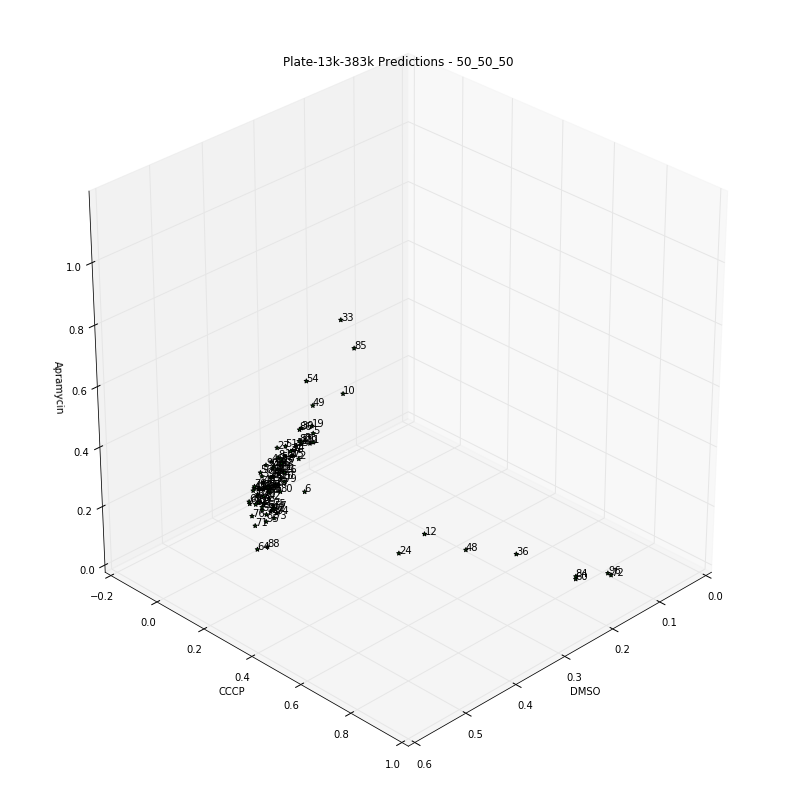

In [268]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13k-383k Predictions - 50_50_50")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

## Drug 13 Plate with equal ratio model: 383k - Wavelet Smoothing

In [ ]:
model = load_model('model_lstm383kSmooth_50_50_50-142--0.742.hdf5')

In [269]:
df_plate_test = pd.read_csv('13plate_TEST_WELL.csv')
df_plate_test.iloc[:,1:451] = waveletSmooth(df_plate_test.iloc[:,1:451].values.ravel()).reshape(df_plate_test.shape[0],450)

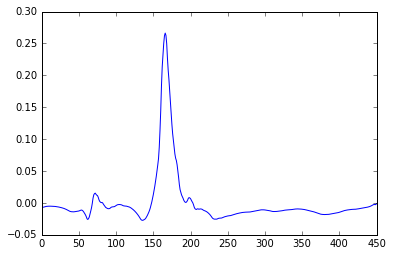

In [273]:
plt.plot(range(1,451),df_plate_test.iloc[7,1:451])

In [274]:
g = globals()
for i in range(1,97):
    label_array = '13_labels_{0}'.format(i)
    trace_array = '13_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,1:451].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,0].values
    

In [275]:
confidence_list = []
for i in range(1,97):

    g['13_predictions_{0}'.format(i)] = []
    g['13_predictions_{0}'.format(i)] = model.predict([g['13_trace_{0}'.format(i)]])
    
    g['13_plabels_{0}'.format(i)] = np.argmax( g['13_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['13_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')


[0.46107697 0.16919364 0.34557867 0.02415082]


[0.4791941  0.16261576 0.33403784 0.02415231]


[0.46197212 0.1517176  0.35842657 0.02788371]


[0.49896252 0.17338172 0.3054342  0.02222138]


[0.46137747 0.15622126 0.35900992 0.0233917 ]


[0.47479028 0.19686404 0.3048497  0.02349585]


[0.4957669  0.16048996 0.3225258  0.02121721]


[0.47102207 0.15655723 0.34341532 0.02900549]


[0.45835313 0.15628438 0.35963404 0.02572832]


[0.36940446 0.11511357 0.48200613 0.03347573]


[0.46670064 0.15631533 0.3541793  0.0228047 ]


[0.5101746  0.3021779  0.17390622 0.01374131]


[0.4759628  0.16244154 0.33776844 0.02382722]


[0.48390532 0.15785038 0.33357382 0.02467086]


[0.48218897 0.15436965 0.33599523 0.02744602]


[0.49198827 0.16270065 0.32225338 0.02305771]


[0.49561083 0.16202193 0.31825116 0.02411586]


[0.4848705  0.16432416 0.32822356 0.02258165]


[0.47549015 0.15280817 0.34477884 0.02692286]


[0.50445086 0.18697728 0.28685367 0.02171794]


[0.49368    0.17080286 0.31171823 0.0237

In [276]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

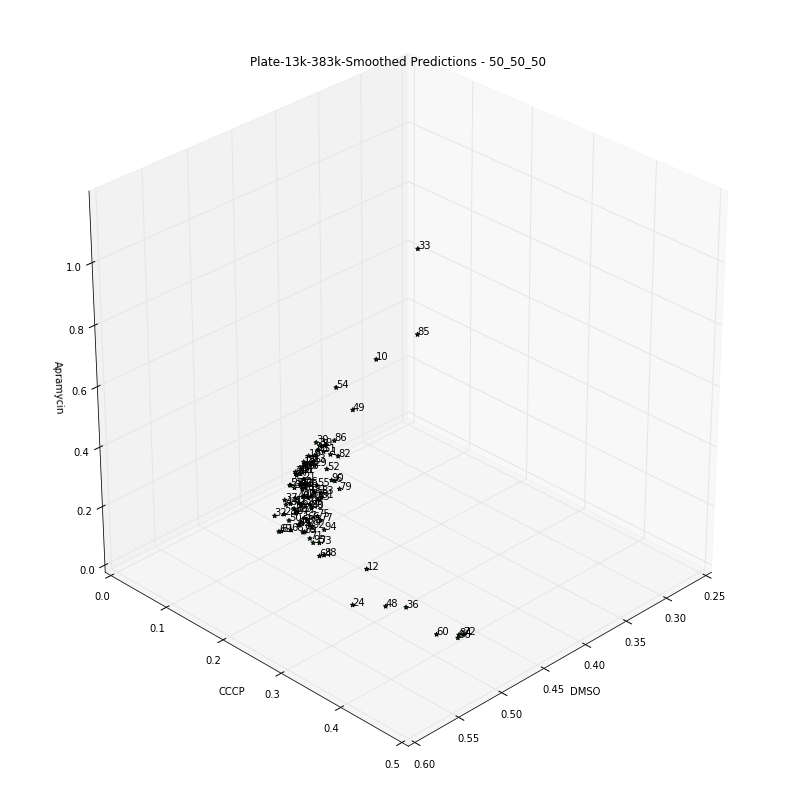

In [279]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13k-383k-Smoothed Predictions - 50_50_50")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

## Drug Screen Test - Model Predictions 

In [280]:
df_plate_test = pd.read_csv('drug_screen_2m.csv')

In [293]:
g = globals()
for i in range(1,3073):
    trace_array = 'screen_trace_{0}'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,2:452].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)


In [286]:
model = load_model('model_lstm383k_50_50_50-28--0.700.hdf5')

In [294]:
confidence_list = []
for i in range(1,3073):
    if(i%100==0):
        print(i)
    g['screen_predictions_{0}'.format(i)] = []
    g['screen_predictions_{0}'.format(i)] = model.predict([g['screen_trace_{0}'.format(i)]])
    
    g['screen_plabels_{0}'.format(i)] = np.argmax( g['screen_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['screen_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['screen_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')


[0.4601346  0.2150102  0.29142335 0.03343193]


[0.45151865 0.31089783 0.21677415 0.02080902]


[0.48863915 0.25905147 0.23153178 0.02077752]


[0.41760746 0.19573845 0.21695368 0.16970037]


[0.21460076 0.7316879  0.05020825 0.00350308]


[0.46578696 0.31190544 0.20373628 0.01857147]




KeyboardInterrupt: 

## Downsample Well Test on 300 & 200 timesteps

In [40]:
df_plate_test = pd.read_csv('data383k_50_50_50_TEST_WELL.csv')

In [41]:
df_plate_test = df_plate_test.iloc[np.asarray(np.where(np.less_equal(df_plate_test.iloc[:,1],96))).tolist()[0],:]
df_plate_test.iloc[:,2:202] = np.reshape(np.append(np.array([]),signal.resample(df_plate_test.iloc[:,2:452].values,200,axis=1)),(df_plate_test.shape[0],200))
df_plate_test = df_plate_test.drop(columns=df_plate_test.columns[202:904])

In [37]:
model = load_model('model_lstm1k_200down-46--0.840.hdf5')

In [43]:
g = globals()
confidence_list = []

for i in range(1,97):
    label_array = 'labels_{0}y'.format(i)
    trace_array = 'trace_{0}y'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,1]==i)).tolist()[0],:].iloc[:,2:202].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 200)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,1]==i)).tolist()[0],:].iloc[:,0].values
    
    g['predictions_{0}'.format(i)] = []
    g['predictions_{0}'.format(i)] = model.predict([g['trace_{0}y'.format(i)]])
    
    g['plabels_{0}'.format(i)] = np.argmax( g['predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[9.5121300e-01 4.6332754e-02 3.6186429e-05 2.4180440e-03]


[9.3431443e-01 6.4720295e-02 1.8873444e-04 7.7677978e-04]


[0.9255286  0.05157201 0.01167122 0.01122805]


[0.8782026  0.05630385 0.04263081 0.0228626 ]


[9.4014227e-01 5.4492287e-02 6.7417929e-04 4.6912879e-03]


[9.2445195e-01 7.4806370e-02 2.5344937e-04 4.8846193e-04]


[8.8376355e-01 6.1914336e-02 8.7102904e-04 5.3451035e-02]


[0.85405034 0.03640141 0.07084718 0.03870109]


[0.9401108  0.0568509  0.00199868 0.00103955]


[8.9507383e-01 1.0466505e-01 2.9544335e-05 2.3155182e-04]


[9.7407782e-01 2.5564782e-02 2.4963554e-04 1.0773765e-04]


[0.8457081  0.04541371 0.08934158 0.01953683]


[0.70120186 0.03434883 0.19884934 0.06559983]


[0.92012215 0.06398667 0.0148334  0.00105775]


[9.3341357e-01 6.5274820e-02 8.0400705e-04 5.0745904e-04]


[0.93991244 0.05055611 0.00109164 0.00843967]


[0.74136204 0.05829808 0.1565785  0.04376126]


[0.9476102  0.04795562 0.00147539 0.00295874]


[9.3104750e-01 6.8737775e-02 6.6713685e-

In [44]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

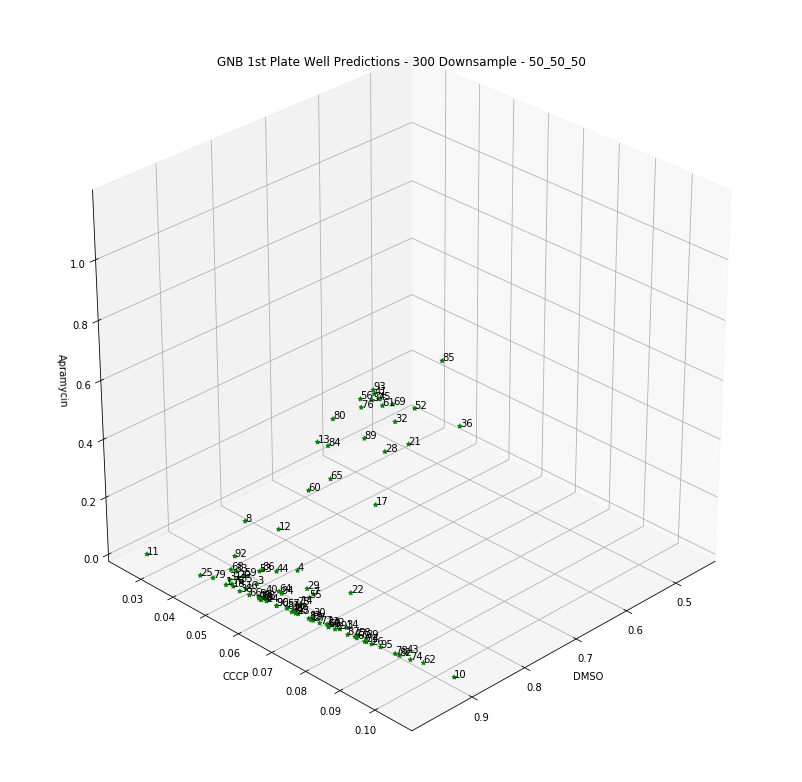

In [48]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

# #For DMSO
# circle = Circle((0.6972626778257995,0.2069872674383536),0.04355071625075986*3,alpha = .5, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09491003647509243,zdir="z")

# #For CCCP
# circle = Circle((0.44048276293177563,0.5312704993646686,),0.10769456075336148*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02800101933593885,zdir="z")

# #For Apramycin
# circle = Circle((0.19924033195990273,0.7733766589409266),0.1602778310822497*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.02411248715473518,zdir="y")

well_number = np.arange(1,97)
# classes = ['DMSO','CCCP','Apramycin']
# class_colours = ['r','b','k']
# recs = []
# for i in range(0,len(class_colours)):
#     recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
# plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,1.2)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("GNB 1st Plate Well Predictions - 300 Downsample - 50_50_50")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

## Geometric Mean - Calculation

In [49]:
df_plate_test = pd.read_csv('data383k_50_50_50_TEST_WELL.csv')

In [ ]:
g = globals()
confidence_list = []

for i in range(1,97):
    label_array = 'labels_{0}y'.format(i)
    trace_array = 'trace_{0}y'.format(i) 
    #categorize data according to wells
    g[trace_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,1]==i)).tolist()[0],:].iloc[:,2:453].values
    g[trace_array] = g[trace_array].reshape(g[trace_array].shape[0], 1, 450)
    g[label_array] = df_plate_test.iloc[np.asarray(np.where(df_plate_test.iloc[:,1]==i)).tolist()[0],:].iloc[:,0].values
    
    g['predictions_{0}'.format(i)] = []
    g['predictions_{0}'.format(i)] = model.predict([g['trace_{0}y'.format(i)]])
    
    g['plabels_{0}'.format(i)] = np.argmax( g['predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

In [65]:
print(sum(list([len(idx_apramycin), len(idx_dmso), len(idx_cccp), len(idx_corr)] )))

479


## New std Metric for Calc

In [91]:
dfsave = pd.read_csv('Confidence_DrugScreen.csv')

In [102]:
def calcstd(idx,pd,cluster,num):
    
    #pass the indices of just the drugs
    std = [np.std(pd.iloc[idx,0].values), np.std(pd.iloc[idx,1].values), np.std(pd.iloc[idx,2].values) ]
    s = []
    if(cluster=="dmso"):
        mean = np.mean(pd.iloc[idx,0].values)
    elif(cluster=="cccp"):
        mean = np.mean(pd.iloc[idx,1].values)
    elif(cluster=="apramycin"):
        mean = np.mean(pd.iloc[idx,2].values)
        
    for i in range(0,len(idx)):
        s.append(np.divide(np.linalg.norm(pd.iloc[idx,num].values[i] - mean),max(std)))
    return s

for cluster in ["dmso", "cccp"]:
    print("Apramycin Wells from "+cluster+":  ",calcstd(idx_apramycin, dfsave, cluster, 2))
    
# for cluster in ["apramycin", "cccp"]:
#     print("DMSO Wells from "+cluster+":  ",calcstd(idx_dmso, alldrug_pd, cluster, 0))
    
# for cluster in ["dmso", "apramycin"]:
#     print("CCCP Wells from "+cluster+":  ",calcstd(idx_cccp, alldrug_pd, cluster,1))

Apramycin Wells from dmso:   [0.8156989823778841, 0.8562199855568813, 1.6244405153489099, 0.6354102630222939, 0.707814004377715, 1.630258899621381, 0.8814315908451252, 0.7811946769873395, 1.6780046466322398, 0.5006272470000517, 0.6253693459981826, 0.8841933586528311, 1.686693266559102, 1.6042857879257806, 1.6027733212173985, 0.20040111938913763, 0.7228490643469543, 1.5274851700816412, 0.8379331266375215, 1.664984603666411, 1.313310151142395, 0.25454056280017096, 0.9207323866601707, 0.956980030023699, 0.07129098417327663, 0.280583384496358, 0.7246337518037604, 0.051162532557956095, 0.15817285963770392, 1.257408382453932, 0.12180236059628001, 1.0806744762345986, 0.4522715106146845, 0.5707036386223965, 1.4989483108708133, 0.17855760847426477, 1.5604213956960182, 1.366876767370666, 0.4548697193463573, 0.764159733329382, 0.5379238850210797, 0.8094851787566918, 0.6362957483026593, 1.6016744586848182, 1.0724770901635021, 1.47900650843992, 1.608783205286822, 0.21839907628453273, 0.124962015462

In [95]:
dfsave.loc[:,'DMSO'].head()


0    0.460135
1    0.451519
2    0.488639
3    0.417608
4    0.214601
Name: DMSO, dtype: float64